Num drive log image paths: 11025
Num drive log steering angles: 11025
Min drive log steering angle: -1.23762889856
Max drive log steering angle: 1.28507009882


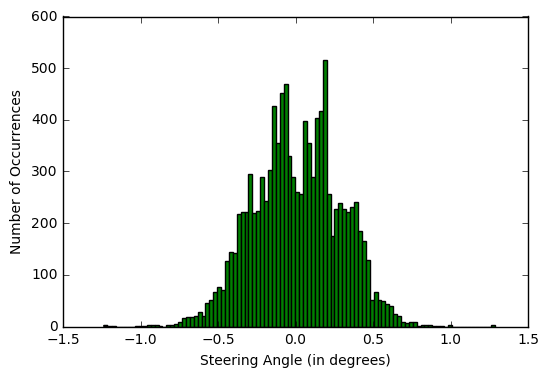

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

drive_log_image_paths = [] #file paths (left, center, and right images are all folded in to this vector of image paths)
drive_log_steering_angles = [] #steering angle associated with drive_log_image_paths
angle_offset = 0.3
cur_steering_angle = 0.0

#load the driving log data (folding in the left, center, and right images into one vector)
with open('driving_log.csv') as file_handle:
    #view file rows as a dictionary (based on header row)
    dict_reader = csv.DictReader(file_handle)
    #get current row as dictionary
    for cur_dict_line in dict_reader:
        #get steering angle from cur_row
        cur_steering_angle = float(cur_dict_line['steering']) 
        #get rid of zero degree angles
        if (cur_steering_angle != 0):
            #add the left, center, and right image paths from cur_row 
            drive_log_image_paths.append((cur_dict_line['left']).strip())
            drive_log_image_paths.append((cur_dict_line['center']).strip())
            drive_log_image_paths.append((cur_dict_line['right']).strip())
            #append steering angle + angle offset (for left)
            drive_log_steering_angles.append(cur_steering_angle + np.random.uniform(low=0.2, high=angle_offset))
            #append center steering angle (no change)
            drive_log_steering_angles.append(cur_steering_angle)
            #append steering angle - angle offset (for right)
            drive_log_steering_angles.append(cur_steering_angle - np.random.uniform(low=0.2, high=angle_offset))
        
#convert to array
drive_log_steering_angles = np.array(drive_log_steering_angles)
drive_log_image_paths = np.array(drive_log_image_paths)
print("Num drive log image paths:", len(drive_log_image_paths))
print("Num drive log steering angles:", len(drive_log_steering_angles))
print("Min drive log steering angle:", min(drive_log_steering_angles))
print("Max drive log steering angle:", max(drive_log_steering_angles))
num_bins = 100
plt.hist(drive_log_steering_angles, num_bins, facecolor='g')
plt.xlabel('Steering Angle (in degrees)')
plt.ylabel('Number of Occurrences')
plt.show()

In [2]:
from sklearn.utils import shuffle

#shuffle data
drive_log_image_paths, drive_log_steering_angles = shuffle(drive_log_image_paths, drive_log_steering_angles)

In [3]:
from sklearn.model_selection import train_test_split

#carve out a portion of the training set to use for model validation
X_train, X_validation, y_train, y_validation = train_test_split(drive_log_image_paths, drive_log_steering_angles, \
                                                                test_size=0.2, random_state=0)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_validation shape: ", X_validation.shape)
print("y_validation shape: ", y_validation.shape)

X_train shape:  (8820,)
y_train shape:  (8820,)
X_validation shape:  (2205,)
y_validation shape:  (2205,)


In [4]:
import matplotlib.image as mpimg

#Process validation data
X_validation_temp = []

#load images
for image_path in X_validation:
    image = mpimg.imread(image_path)
    X_validation_temp.append(image)
    
X_validation = np.array(X_validation_temp)    

print("X_validation shape: ", X_validation.shape)

## VALIDATION ##
#convert to float
#X_validation = X_validation.astype(np.float)
#normalize
#X_validation /= 255.0

## CROP ##
#def crop_validation(X):
#    return X[:, 70:136, 60:260]

#print("Pre-crop shape:", X_validation.shape)
#X_validation = crop_validation(X_validation)
#print("Post-crop shape:", X_validation.shape)

X_validation shape:  (2205, 160, 320, 3)


In [5]:
from keras.models import Sequential
from keras.layers import Cropping2D, Lambda
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D

#NVIDIA model
def cnn_model():
    model = Sequential()
    #CROP: Input = 160x320x3, Output = 66x200x3
    model.add(Cropping2D(cropping=((70, 24), (60, 60)), input_shape=(160, 320, 3)))
    #NORMALIZE: Input = 66x200x3, Output = 66x200x3
    model.add(Lambda(lambda x: x / 255))
    ## LAYER 1 ##
    #CONVOLUTIONAL: Input = 66x200x3, Output = 31x98x24
    #filter: 5x5, input depth: 3, output depth: 24
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', activation="relu", init='lecun_uniform'))
    ## LAYER 2 ##
    #CONVOLUTIONAL: Input = 31x98x24, Output = 14x47x36
    #filter: 5x5, input depth: 24, output depth: 36
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid', activation="relu", init='lecun_uniform'))
    ## LAYER 3 ##
    #CONVOLUTIONAL: Input = 14x47x36, Output = 5x22x48
    #filter: 5x5, input depth: 36, output depth: 48
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid', activation="relu", init='lecun_uniform'))
    ## LAYER 4 ##
    #CONVOLUTIONAL: Input = 5x22x48, Output = 3x20x64
    #filter: 3x3, input depth: 48, output depth: 64
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='valid', activation="relu", init='lecun_uniform'))
    ## LAYER 5 ##
    #CONVOLUTIONAL: Input = 3x20x64, Output = 1x18x64
    #filter: 3x3, input depth: 64, output depth: 64
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='valid', activation="relu", init='lecun_uniform'))
    #FLATTEN INPUT WHILE RETAINING BATCH: Input = 1x18x64, Output = 1152x1
    model.add(Flatten())
    ## LAYER 6 ##
    #FULLY-CONNECTED: Input = 1152, Output = 100
    model.add(Dense(100, activation='relu', init='lecun_uniform'))
    ## LAYER 7 ##
    #FULLY-CONNECTED: Input = 100, Output = 50
    model.add(Dense(50, activation='relu', init='lecun_uniform'))
    #REGULARIZATION: Dropout
    model.add(Dropout(0.5))
    ## LAYER 8 ##
    #FULLY-CONNECTED: Input = 50, Output = 10
    model.add(Dense(10, activation='relu', init='lecun_uniform'))
    #REGULARIZATION: Dropout
    model.add(Dropout(0.5))
    ## OUTPUT LAYER ##
    #FULLY-CONNECTED: Input = 10, Output = 1
    model.add(Dense(1, init='lecun_uniform'))
    return model

Using TensorFlow backend.


In [6]:
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import random
import cv2

#rotate training example
def generate_rotation_matrix(image, steering_angle):
    #determine center point of source (training_example) --- used for center of rotation
    object_center_point = ((image.shape[1] / 2), (image.shape[0] / 2))
    #keep original scale of image
    object_scale = 1
    #randomly select an angle within a uniform distribution (rotation-factor, negative is clock-wise)
    object_rotation_angle = np.random.uniform(low=-5, high=5)
    #adjust steering angle based on x translation (invert sign of result given negative rotation is clock-wise)
    steering_angle += -(object_rotation_angle * 0.1)
    #return rotation matrix based on above values
    return (cv2.getRotationMatrix2D(object_center_point, object_rotation_angle, object_scale), steering_angle)   
    
#translate (change position of) training example
#translation matrix found here: http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html
def generate_translation_matrix(image, steering_angle):
    #randomly translate x
    translated_x = np.random.uniform(low=-15, high=15)
    #adjust steering angle based on x translation
    steering_angle += translated_x * 0.005
    #randomly translate y
    translated_y = np.random.uniform(low=-15, high=15)
    #return translation matrix based on above values
    return (np.float32([[1, 0, translated_x],[0, 1, translated_y]]), steering_angle)

#perform brightness adjustment (brighten or darken)
def perform_brightness_adjustment(image, steering_angle):
    #convert RGB to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #randomly adjust V channel
    hsv[:, :, 2] = hsv[:, :, 2] * np.random.uniform(low=0.2, high=1.0)
    #convert back to RGB and return (steering angle is unaltered)
    return (cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB), steering_angle)

#randomly rotate object (within specified matrix bounds)
def perform_rotation(image, steering_angle):
    #get rotation matrix along with adjusted steering angle
    object_transform_matrix, steering_angle = generate_rotation_matrix(image, steering_angle)
    #return randomly rotated image with adjusted steering angle
    return (cv2.warpAffine(image, object_transform_matrix, (image.shape[1], image.shape[0])), steering_angle)

#perform y-axis flip
def perform_y_axis_flip(image, steering_angle):
    #return y-axis flipped image and flipped steering angle
    return (np.fliplr(image), -steering_angle)

#randomly translate object (within specified matrix bounds)
def perform_translation(image, steering_angle):
    #get tanslation matrix along with adjusted steering angle
    object_transform_matrix, steering_angle = generate_translation_matrix(image, steering_angle)
    #return randomly translated image with adjusted steering angle
    return (cv2.warpAffine(image, object_transform_matrix, (image.shape[1], image.shape[0])), steering_angle)

#generate a synthetic example from the supplied training example
def generate_synthetic_training_example(image, steering_angle):
    #list of transformation functions available
    #transformation_functions = [perform_translation, perform_brightness_adjustment, perform_y_axis_flip, perform_rotation]
    transformation_functions = [perform_translation, perform_brightness_adjustment, perform_y_axis_flip]
    #choose the number of transformations to perform at random (between 1 and 3)
    num_transformations_to_perform = random.randint(1, len(transformation_functions))
    #perform the number of transformations chosen
    for _ in range(0, num_transformations_to_perform):
        #select a transformation function at random
        selected_transformation_function = random.choice(transformation_functions)           
        #execute the transformation function and return the result
        image, steering_angle = selected_transformation_function(image, steering_angle)
        #ensure each transformation can only be performed once by removing it from the list
        transformation_functions.remove(selected_transformation_function)
    #return transformed image & adjusted steering angle
    return (image, steering_angle)

#on-the-fly synthetic data generator
def generate_synthetic_training_batch(X_train, y_train, batch_size):
    #loop forever
    while True:
        X_train_synthetic = []  #batch of images (after-processing)
        y_train_synthetic = []  #batch of steering angles (after-processing)
        #shuffle data
        X_train, y_train = shuffle(X_train, y_train)
        #create enough synthetic images to fill a batch
        for i in range(batch_size):
            #randomly select an index within X_train (zero indexed)
            random_index = np.random.randint(len(X_train))
            #load image
            image = mpimg.imread(X_train[random_index])
            #create a synthetic example based on that image
            synthetic_image, steering_angle = generate_synthetic_training_example(image, y_train[random_index])
            #append synthetic image
            X_train_synthetic.append(synthetic_image)
            #append steering angle
            y_train_synthetic.append(steering_angle)
        #yeild a new batch
        yield (np.array(X_train_synthetic), np.array(y_train_synthetic))

#generate batches of validation data
def generate_validation_batch(X_validation, y_validation, batch_size):
    #determine validation set length
    num_validation_examples = len(X_validation)
    #loop forever
    while True:
        #shuffle data
        X_validation, y_validation = shuffle(X_validation, y_validation)
        #walk through the validation set yeilding batches equal to batch size
        for offset in range(0, num_validation_examples, batch_size):
            yield (X_validation[offset:offset+batch_size], y_validation[offset:offset+batch_size])

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#get a handle to the model
model = cnn_model()    
#init the optimizer, loss function, and metrics for the model
model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])
#model.summary()

#generates a synthetic batch based on the training data
training_generator = generate_synthetic_training_batch(X_train, y_train, batch_size=256)
#fetches a batch from the validation data we carved out earlier
validation_generator = generate_validation_batch(X_validation, y_validation, batch_size=256)

#early stopping and checkpoint
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min'),
    ModelCheckpoint('model_best.h5', monitor='val_loss', verbose=1, save_best_only=True, \
                    mode='min', save_weights_only=False, period=1)
]

#fit the model on batches of real-time synthetic data:
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    samples_per_epoch=25600,
                    nb_val_samples=5120,
                    nb_epoch=5,
                    verbose=2,
                    callbacks=callbacks_list)

#save the model
model.save('model.h5')

Epoch 1/5
Epoch 00000: val_loss improved from inf to 0.03369, saving model to model_best.h5
87s - loss: 0.0624 - acc: 0.0000e+00 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 2/5
Epoch 00001: val_loss improved from 0.03369 to 0.03000, saving model to model_best.h5
82s - loss: 0.0460 - acc: 0.0000e+00 - val_loss: 0.0300 - val_acc: 0.0000e+00
Epoch 3/5
Epoch 00002: val_loss improved from 0.03000 to 0.02901, saving model to model_best.h5
83s - loss: 0.0424 - acc: 0.0000e+00 - val_loss: 0.0290 - val_acc: 0.0000e+00
Epoch 4/5
Epoch 00003: val_loss improved from 0.02901 to 0.02706, saving model to model_best.h5
83s - loss: 0.0394 - acc: 0.0000e+00 - val_loss: 0.0271 - val_acc: 0.0000e+00
Epoch 5/5
Epoch 00004: val_loss did not improve
84s - loss: 0.0394 - acc: 0.0000e+00 - val_loss: 0.0308 - val_acc: 0.0000e+00
